# Loss Function Variation in System Identification With Neural Networks
## Mohammad Qori Aziz Hakiki - 23222020


System Model:

$$y(k) = 1.37u(k) - 0.95u(k-1) + 3.2y(k-1) + 2.93 y(k-2)$$

### 1. Generate Input and Output For System

In [1]:
# import library
import os
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from collections import OrderedDict
import matplotlib.pyplot as plt

In [2]:
# Import dataset for system
dataset = np.genfromtxt('data_motor_22Juni_ts100/1.txt',delimiter=';')
print(dataset)

# Get first column as input, skipping the header
input=torch.as_tensor(dataset[1:, 0], dtype=torch.float32)
input=torch.reshape(input, (len(input), 1))

# Normalize input
input = input / 10 

print(input)

[[      nan       nan       nan       nan]
 [ 1.        0.        0.        1.      ]
 [ 1.        1.06069   3.342621  1.      ]
 ...
 [ 0.       -0.046625  0.        0.      ]
 [ 0.       -0.298288  0.        0.      ]
 [ 0.       -0.298288  0.        0.      ]]
tensor([[0.1000],
        [0.1000],
        [0.1000],
        ...,
        [0.0000],
        [0.0000],
        [0.0000]])


In [3]:
# Generate output for system
output = torch.zeros((len(input),1))
print(output)

# Coefficient for our model. Each column corresponds to x(k), x(k-1), y(k-1), and y(k-2)
regressor = np.array([[1.37117312, -0.94887817, 3.1960358, 2.92779642]])
print(regressor)

 # Calculate output from our model
for i in range(len(output)):
    if i >= 0 :
        output[i] = regressor[0][0] * input[i]
        continue

    if i >= 1:
        output[i] =  regressor[0][0] * input[i] + regressor[0][1] * input[i-1] + regressor[0][2] * output[i-1]
        continue

    if i>=2 :
        output[i] =  regressor[0][0] * input[i] + regressor[0][1] * input[i-1] + regressor[0][2] * output[i-1] +  regressor[0][3] * output[i-2]

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])
[[ 1.37117312 -0.94887817  3.1960358   2.92779642]]


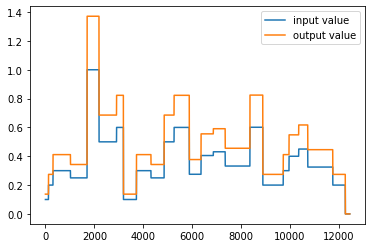

In [4]:
# Plot input and output 
input_det = input.detach().numpy()
output_det = output.detach().numpy()
plt.plot(input_det, label='input value')
plt.plot(output_det, label='output value')
plt.legend()

### 2. Parameter Estimation with Least Square Method

Here we apply time delay to our data. Suppose we predict that our DC motor transfer function will be like this:

$$H(z) = \frac{Y(z)}{U(z)} = \frac{b_{0} + b_{1}z^{-1}}{1 - a_{1}z^{-1} - a_{2}z^{-2}}$$

In time-domain, 

$$y(k) =a_{1}y(k-1) + a_{2}y(k-2) + b_{0}u(k) + b_{1}u(k-1)$$

Based on the reference paper, we will estimate the $a_{i}$ and $b_{j}$ parameter from the weight of the NN.  

To do so, the neural network inputs will be the delayed target output and inputs, in our case $y(k-1), y(k-2), u(k),$ and $u(k-1)$.


In [5]:
# Time delay block definition
def timedelayblock(input, target, inp_order, target_order):
    delayed_nn_input = input

    # Append delayed input
    for i in range(1, inp_order+1):
        concated_tensor =torch.roll(input, i, 0)
        for j in range(i):
            concated_tensor[j, 0] = 0 # force zeroing delayed input
        delayed_nn_input= torch.cat((delayed_nn_input, concated_tensor), 1)
    
    # Append delayed input
    for k in range(1, target_order+1):
        concated_tensor = torch.roll(target, k, 0)
        for l in range(k):
            concated_tensor[l, 0] = 0 # force zeroing delayed input
        delayed_nn_input= torch.cat((delayed_nn_input, concated_tensor), 1)
    return delayed_nn_input

# Initialize system order
inp_order = 1
out_order = 2
# Create x(k), x(k-1), y(k-1), and y(k-2)
nn_input= timedelayblock(input, output, inp_order, out_order)
print(nn_input[0:5, :])
print(nn_input.size())

tensor([[0.1000, 0.0000, 0.0000, 0.0000],
        [0.1000, 0.1000, 0.1371, 0.0000],
        [0.1000, 0.1000, 0.1371, 0.1371],
        [0.1000, 0.1000, 0.1371, 0.1371],
        [0.1000, 0.1000, 0.1371, 0.1371]])
torch.Size([12450, 4])


In [6]:
# Split training and test data
nn_input_train = nn_input[:10000, :]
nn_input_test = nn_input[10000:, :]

y_train =output[:10000, :]
y_test = output[10000:, :]

print(torch.sum(y_train))

tensor(5267.9521)


#### Define the NN model that will be used.  
Here we will add hidden layer and act function based on the parameters provided.

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_features, hidden_dim, hidden_layer, out_classes):
        super(NeuralNetwork, self).__init__()
        # Create ordered Dictionary based on the number of hidden_layer
        sequence = OrderedDict()
        for layer in range(hidden_layer):
            if layer == 0:
                sequence['hidden_layer_{}'.format(layer)] =nn.Linear(
                    in_features, hidden_dim, bias=False)
                sequence['activation_{}'.format(layer)] =  nn.Tanh()
                continue
            # For layer not in the input layer
            sequence['hidden_layer_{}'.format(layer)] = nn.Linear(
                hidden_dim, hidden_dim, bias=False)
            sequence['activation_{}'.format(layer)] = nn.Tanh()
        # Insert output layer
        sequence['output_layer'] = nn.Linear(hidden_dim, out_classes, bias=False)

        # print(sequence)
        # return the sequential model
        self.layer_stack = nn.Sequential(sequence)
        

    def forward(self, x):
        x = self.layer_stack(x)
        return x

In [8]:
# Variable declaration
# Since we have u(k), u(k-1), y(k-1), and y(k-2), we have 4 inputs.

in_features=inp_order + out_order +1  # how many Variables are in the dataset
hidden_dim= inp_order + out_order +1 # hidden i/o
hidden_layer=5 # how many hidden layers
output_dim= 1   # number of classes
epoch = 100 

In [9]:
clf=NeuralNetwork(in_features,hidden_dim, hidden_layer, output_dim)
print(clf)

params = clf.parameters()
# print(len(params))

for p in params:
    print(p.size())  # conv1's .weight
    print(p)

NeuralNetwork(
  (layer_stack): Sequential(
    (hidden_layer_0): Linear(in_features=4, out_features=4, bias=False)
    (activation_0): Tanh()
    (hidden_layer_1): Linear(in_features=4, out_features=4, bias=False)
    (activation_1): Tanh()
    (hidden_layer_2): Linear(in_features=4, out_features=4, bias=False)
    (activation_2): Tanh()
    (hidden_layer_3): Linear(in_features=4, out_features=4, bias=False)
    (activation_3): Tanh()
    (hidden_layer_4): Linear(in_features=4, out_features=4, bias=False)
    (activation_4): Tanh()
    (output_layer): Linear(in_features=4, out_features=1, bias=False)
  )
)
torch.Size([4, 4])
Parameter containing:
tensor([[ 0.1638, -0.1322, -0.0107, -0.0433],
        [ 0.1056, -0.0680,  0.2927, -0.3713],
        [ 0.4332,  0.2654, -0.1090, -0.3878],
        [-0.2841,  0.4521,  0.1136, -0.3497]], requires_grad=True)
torch.Size([4, 4])
Parameter containing:
tensor([[-0.4747,  0.3834,  0.2931,  0.0904],
        [ 0.4263, -0.3856,  0.3223, -0.3716],
      

#### Compute Weight and Bias

##### Initialize loss and optimizer

In [10]:
# # Construct least square loss function for learning
# from logging import critical


# class LeastSquareLoss(nn.Module):
#     def __init__(self):
#         super(LeastSquareLoss, self).__init__()
 
#     def forward(self, inputs, targets):
#         difference = targets - inputs
#         loss_value = torch.sum(difference**2)
#         return loss_value


# criterion = LeastSquareLoss()
criterion = nn.MSELoss()
# Construct the optimizer (Stochastic Gradient Descent in this case)
optimizer = torch.optim.SGD(clf.parameters(), lr = 0.3)

In [11]:
for e in range(epoch):
   # Forward pass: Compute predicted y by passing x to the model
   y_pred = clf(nn_input_train)

   # Compute and print loss
   loss = criterion(y_pred, y_train)
   print('epoch: ', e,' loss: ', loss.item())

   # Zero gradients, perform a backward pass, and update the weights.
   optimizer.zero_grad()

   # perform a backward pass (backpropagation)
   loss.backward()

   # Update the parameters
   optimizer.step()

epoch:  0  loss:  0.3543110191822052
epoch:  1  loss:  0.353139191865921
epoch:  2  loss:  0.3520854115486145
epoch:  3  loss:  0.3510313332080841
epoch:  4  loss:  0.34986698627471924
epoch:  5  loss:  0.3484770655632019
epoch:  6  loss:  0.34672635793685913
epoch:  7  loss:  0.34444358944892883
epoch:  8  loss:  0.341400146484375
epoch:  9  loss:  0.33728060126304626
epoch:  10  loss:  0.3316386342048645
epoch:  11  loss:  0.3238316476345062
epoch:  12  loss:  0.3129258453845978
epoch:  13  loss:  0.29756948351860046
epoch:  14  loss:  0.27586835622787476
epoch:  15  loss:  0.24542970955371857
epoch:  16  loss:  0.20408321917057037
epoch:  17  loss:  0.15230046212673187
epoch:  18  loss:  0.09749540686607361
epoch:  19  loss:  0.05444904789328575
epoch:  20  loss:  0.03271016851067543
epoch:  21  loss:  0.026057342067360878
epoch:  22  loss:  0.024429116398096085
epoch:  23  loss:  0.02370799146592617
epoch:  24  loss:  0.023102177307009697
epoch:  25  loss:  0.02251606434583664
epoc

In [12]:
for param in clf.parameters():
   print(param)

# Loss testing
y_pred_test = clf(nn_input_test)
print(y_pred_test)
loss = criterion(y_pred_test, y_test)
print(' loss: ', loss.item())

Parameter containing:
tensor([[ 0.0872, -0.2004, -0.1041, -0.1367],
        [ 0.1901,  0.0104,  0.4001, -0.2638],
        [ 0.4205,  0.2533, -0.1256, -0.4043],
        [-0.2044,  0.5283,  0.2181, -0.2452]], requires_grad=True)
Parameter containing:
tensor([[-0.5479,  0.4327,  0.2817,  0.1146],
        [ 0.4951, -0.4273,  0.3331, -0.3874],
        [-0.5014,  0.2479,  0.2442, -0.2680],
        [-0.0477, -0.2043, -0.0909,  0.0843]], requires_grad=True)
Parameter containing:
tensor([[ 0.1959,  0.0344, -0.2087,  0.1441],
        [ 0.4705, -0.5999,  0.2056, -0.0563],
        [ 0.4842, -0.5810,  0.1060,  0.3121],
        [ 0.1878,  0.1657, -0.0197,  0.2935]], requires_grad=True)
Parameter containing:
tensor([[-0.4759,  0.5431,  0.5523,  0.1860],
        [-0.0906, -0.1469, -0.2399,  0.0246],
        [-0.1590, -0.5097, -0.7349,  0.1852],
        [-0.1273, -0.3612,  0.0421, -0.0829]], requires_grad=True)
Parameter containing:
tensor([[ 0.1910, -0.1357, -0.7834,  0.1228],
        [-0.6341,  0.010

tensor([[0.5798],
        [0.5798],
        [0.5798],
        ...,
        [0.0000],
        [0.0000],
        [0.0000]], grad_fn=<MmBackward0>)


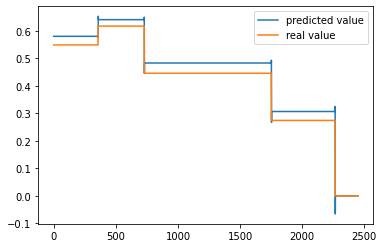

In [13]:
# Print test data
nn_input_test = nn_input_test.detach().numpy()

y_pred_test_detach = y_pred_test.detach().numpy()

y_test = y_test.detach().numpy()
# plt.plot(nn_input_test, label='input value')
plt.plot(y_pred_test_detach, label='predicted value')
plt.plot(y_test, label='real value')
leg = plt.legend()

print(y_pred_test)

##### Transform NN Weights to Transfer Function

In here, we define an NN2TF algorithm. Based on the reference paper, the parameter $a_{j}$ and $b_{i}$ can be estimated by

$$a_{j} = (\sum_{h=1}^H (wout_{h}v_{jh}))$$

$$b_{i} = (\sum_{h=1}^H (wout_{h}w_{ih}))$$

For tanh activation function.

In [14]:
def nn2tf(nn, hidden_layer, inp_order, target_order):
    regressor = np.zeros((1, inp_order+target_order+1))
    wout = nn.state_dict()['layer_stack.output_layer.weight']
    wout = wout.numpy()
    print('wout : ', wout)
    # print(wout.size())
    params = nn.named_parameters()
    i = 0
    for p in params:
        # print(p)

        w_hidden = nn.state_dict()['layer_stack.hidden_layer_{}.weight'.format(i)]
        w_hidden = w_hidden.numpy()
        print('w_hidden : ', w_hidden)
        # Update regressor
        regressor = regressor + (wout @ w_hidden)
        print(regressor)

        i = i + 1
        if i == hidden_layer :
            break
    
    # regressor = regressor * 0.5
    return regressor


regressor = nn2tf(clf, hidden_layer, inp_order, out_order)
print(regressor)

wout :  [[ 0.73570895 -0.7855375   0.1676112   0.677703  ]]
w_hidden :  [[ 0.08719596 -0.20035504 -0.10414492 -0.1366684 ]
 [ 0.19007473  0.01036781  0.40008122 -0.2638328 ]
 [ 0.4205162   0.2533268  -0.12555431 -0.40432718]
 [-0.2044357   0.52833164  0.2180852  -0.24521959]]
[[-0.15322347  0.24496505 -0.26414645 -0.12725341]]
w_hidden :  [[-0.54786015  0.43268165  0.28166065  0.11462629]
 [ 0.49506631 -0.42732647  0.33305198 -0.38739413]
 [-0.50136083  0.24791782  0.24416345 -0.26800498]
 [-0.04768356 -0.20432131 -0.090937    0.08428805]]
[[-1.06153126  0.80205837 -0.33925475  0.27359241]]
w_hidden :  [[ 0.1959167   0.03437458 -0.20872891  0.1440832 ]
 [ 0.47053525 -0.5998624   0.20563285 -0.05627884]
 [ 0.48421106 -0.58100337  0.10597298  0.31214464]
 [ 0.18780501  0.16565362 -0.01967793  0.29354268]]
[[-1.07858145  1.31344369 -0.64992432  0.67505854]]
w_hidden :  [[-0.47585806  0.54308325  0.55225927  0.18599692]
 [-0.09059151 -0.1469408  -0.239853    0.02459552]
 [-0.15900485 -0.50

In [15]:
# Calculate estimated output from our model
y_pred = np.zeros((len(output),1))

nn_input_detach = nn_input.detach().numpy()

for i in range(len(output)):
    if i == 0 :
        y_pred[i] = regressor[0][0] * nn_input_detach[i][0]
        continue
    
    # Fill y(k-1)
    if i >= 1 :
        nn_input_detach[i][2] = y_pred[i-1]
    
        # Fill y(k-2)
    if i >=2 :
        nn_input_detach[i][3] = y_pred[i-2]

    for j in range (len(regressor)):
        y_pred[i] += regressor[0][j] * nn_input_detach[i][j]

[[-0.06223622]
 [-0.06223622]
 [-0.06223622]
 ...
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]


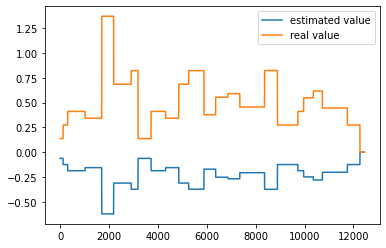

In [16]:
# Plot estimated output

print(y_pred)
plt.plot(y_pred, label='estimated value')
plt.plot(output, label='real value')
leg = plt.legend()

### 3. Estimate Parameter with Genetic Algorithm, Simulated Annealing, and Particle Swarm Opt

#### a. Simulated Annealing

Here we won't redefine delayed input and nn, since we assume the order are the same with the previous method.

In [17]:
## Initialize input and output
# Split training and test data
nn_ga_train = nn_input[:10000, :]
nn_ga_test = nn_input[10000:, :]

y_ga_train =output[:10000, :]
y_ga_test = output[10000:, :]

In [18]:
# Create Network
network=NeuralNetwork(in_features,hidden_dim, hidden_layer, output_dim)
print(network)

params = network.parameters()
# print(len(params))

for p in params:
    print(p.size())
    print(p)

NeuralNetwork(
  (layer_stack): Sequential(
    (hidden_layer_0): Linear(in_features=4, out_features=4, bias=False)
    (activation_0): Tanh()
    (hidden_layer_1): Linear(in_features=4, out_features=4, bias=False)
    (activation_1): Tanh()
    (hidden_layer_2): Linear(in_features=4, out_features=4, bias=False)
    (activation_2): Tanh()
    (hidden_layer_3): Linear(in_features=4, out_features=4, bias=False)
    (activation_3): Tanh()
    (hidden_layer_4): Linear(in_features=4, out_features=4, bias=False)
    (activation_4): Tanh()
    (output_layer): Linear(in_features=4, out_features=1, bias=False)
  )
)
torch.Size([4, 4])
Parameter containing:
tensor([[ 0.1491, -0.0697, -0.4628, -0.0747],
        [-0.4458, -0.2838,  0.2803, -0.4555],
        [-0.0865,  0.1642,  0.2764,  0.1545],
        [-0.0573,  0.0199,  0.2970, -0.1227]], requires_grad=True)
torch.Size([4, 4])
Parameter containing:
tensor([[ 0.1964, -0.0065, -0.2459,  0.4988],
        [-0.0577,  0.0958, -0.2293,  0.2159],
      

#### Compute Weight and Bias

##### Define Simulated Annealing Optimizer and Initialize

In [19]:
print(np.random.random())

0.7132629161764259


In [20]:
import torch
from torch.optim import Optimizer
import torch.nn as nn
import numpy as np
import math
import random

class SimulatedAnnealing(Optimizer):
    def __init__(self, neighborhoodSize = 0.2
                 , loss = nn.MSELoss()
                 , model = None
                 , features = None
                 , labels = None
                 , bounds= None
                 , initTemp= None
                 , finalTemp = 0): #these represent default values, but can be overridden
        self.loss = loss
        self.model = model
        self.bounds = bounds
        self.features = features
        self.labels = labels
        self.neighborhoodSize = neighborhoodSize
        self.currTemp = initTemp
        self.finalTemp = finalTemp
        self.iterPerTemp = 5
        self.stepTemp = 0.01

    def step(self):
        #need to first generate a random new point in the space
        oldOutputs = self.model(self.features)
        oldLoss = self.loss(oldOutputs, self.labels.type(torch.LongTensor))
        # Save init values
        old_state_dict = {}
        for key in self.model.state_dict():
            old_state_dict[key] = self.model.state_dict()[key].clone()

        for name, param in self.model.state_dict().items():
            for i in range(self.iterPerTemp):
            #generate a matrix of random changes in each param element to be added to each param matrix
                if (len(param.shape) == 2):
                    random = torch.Tensor(np.random.uniform(low = self.bounds[0][0], high =self.bounds[0][1]
                                                            , size = (param.shape[0], param.shape[1])))
                else:
                    random = torch.Tensor(np.random.uniform(low = self.bounds[0][0], high = self.bounds[0][1]
                                                            , size = param.shape[0]))
                #now add random to the params to transform them
                new_param = param + random * self.neighborhoodSize
                self.model.state_dict()[name].copy_(new_param)

                newOutputs = self.model(self.features)
                newWeights = self.model.state_dict().items()
                newLoss = self.loss(newOutputs, self.labels.type(torch.LongTensor))

                self.model.load_state_dict(old_state_dict)

                if (newLoss  < oldLoss):
                     #put the old weights back
                     self.model.state_dict()[name].copy_(new_param)
                else:
                    if np.random.random() < math.exp(-(newLoss-oldLoss) / self.currTemp):
                        self.model.state_dict()[name].copy_(new_param)
        self.currTemp -= self.stepTemp
        print(self.currTemp)

In [21]:
lossFunc =  nn.MSELoss()
optimizer = SimulatedAnnealing(loss = lossFunc, model=network, features=nn_ga_train, labels=y_ga_train, bounds = torch.tensor([[-10, 10]]), initTemp = 5)
epoch = 500
for e in range(epoch):

   # Forward pass: Computed predicted y by passing x to the model
   y_pred = network(nn_ga_train)

   # Compute and print loss
   loss = lossFunc(y_pred, y_ga_train)

   # Define termination criteria
   if (optimizer.currTemp-0.00005 <= optimizer.finalTemp) or (loss < 0.008):
      break
   print('epoch: ', e,' loss: ', loss.item())

   # Update the parameters
   optimizer.step()

epoch:  0  loss:  0.322165846824646
4.99
epoch:  1  loss:  0.20991723239421844
4.98
epoch:  2  loss:  0.1543910652399063
4.970000000000001
epoch:  3  loss:  0.24367202818393707
4.960000000000001
epoch:  4  loss:  0.20880933105945587
4.950000000000001
epoch:  5  loss:  0.0834796279668808
4.940000000000001
epoch:  6  loss:  0.062452368438243866
4.9300000000000015
epoch:  7  loss:  0.17963752150535583
4.920000000000002
epoch:  8  loss:  0.1724335253238678
4.910000000000002
epoch:  9  loss:  0.31353089213371277
4.900000000000002
epoch:  10  loss:  0.09779953956604004
4.890000000000002
epoch:  11  loss:  0.2145725041627884
4.880000000000003
epoch:  12  loss:  0.16691207885742188
4.870000000000003
epoch:  13  loss:  0.12900665402412415
4.860000000000003
epoch:  14  loss:  0.10175791382789612
4.850000000000003
epoch:  15  loss:  0.05153079330921173
4.840000000000003
epoch:  16  loss:  0.11639370024204254
4.830000000000004
epoch:  17  loss:  0.017713239416480064
4.820000000000004
epoch:  18  l

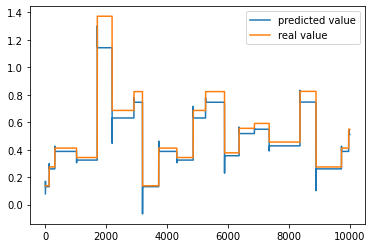

In [22]:
# print train data
y_pred_train = network(nn_ga_train)
y_pred_train_detach = y_pred_train.detach().numpy()

y_train = y_ga_train.detach().numpy()
plt.plot(y_pred_train_detach, label='predicted value')
plt.plot(y_train, label='real value')
plt.legend()

tensor([[0.5112],
        [0.5112],
        [0.5112],
        ...,
        [0.0000],
        [0.0000],
        [0.0000]], grad_fn=<MmBackward0>)


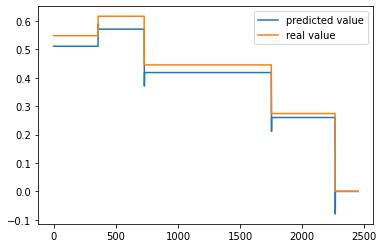

In [23]:
# Print test data
y_pred_test = network(nn_ga_test)

y_pred_test_detach = y_pred_test.detach().numpy()

y_test = y_ga_test.detach().numpy()
# plt.plot(nn_input_test, label='input value')
plt.plot(y_pred_test_detach, label='predicted value')
plt.plot(y_test, label='real value')
leg = plt.legend()

print(y_pred_test)

[[0.  1.5]]
0.39129154291384566
>0 f([0.54531572]) = 0.29737
>1 f([0.50042794]) = 0.25043
>2 f([0.38983443]) = 0.15197
>3 f([0.22438289]) = 0.05035
>4 f([-0.01196397]) = 0.00014
>24 f([0.00677429]) = 0.00005
>26 f([0.00527809]) = 0.00003
>27 f([0.00401163]) = 0.00002
>76 f([0.00367788]) = 0.00001
>81 f([0.00045578]) = 0.00000
>556 f([-0.00018765]) = 0.00000
Done!
f([-0.00018765]) = 0.000000


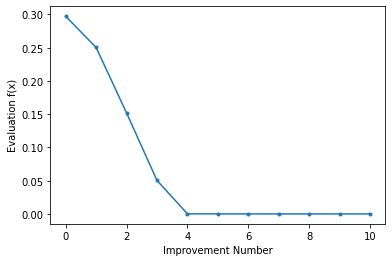

In [24]:
# simulated annealing search of a one-dimensional objective function
from numpy import asarray
from numpy import exp
from numpy.random import randn
from numpy.random import rand
from numpy.random import seed
from matplotlib import pyplot
import random
 
# objective function
def objective(x):
	return x[0]**2.0
 
# simulated annealing algorithm
def simulated_annealing(objective, bounds, n_iterations, step_size, temp):
	# generate an initial point
	best = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
	# evaluate the initial point
	best_eval = objective(best)
	print(best_eval)
	# current working solution
	curr, curr_eval = best, best_eval
	scores = list()
	# run the algorithm
	for i in range(n_iterations):
		# take a step
		candidate = curr + randn(len(bounds)) * step_size
		# evaluate candidate point
		candidate_eval = objective(candidate)
		# check for new best solution
		if candidate_eval < best_eval:
			# store new best point
			best, best_eval = candidate, candidate_eval
			# keep track of scores
			scores.append(best_eval)
			# report progress
			print('>%d f(%s) = %.5f' % (i, best, best_eval))
		# difference between candidate and current point evaluation
		diff = candidate_eval - curr_eval
		# calculate temperature for current epoch
		t = temp / float(i + 1)
		# calculate metropolis acceptance criterion
		metropolis = exp(-diff / t)
		# check if we should keep the new point
		if diff < 0 or rand() < metropolis:
			# store the new current point
			curr, curr_eval = candidate, candidate_eval
	return [best, best_eval, scores]
 
# seed the pseudorandom number generator
seed(1)
# define range for input
bounds = asarray([[0.0, 1.5]])
print(bounds)
# define the total iterations
n_iterations = 1000
# define the maximum step size
step_size = 0.1
# initial temperature
temp = 10
# perform the simulated annealing search
best, score, scores = simulated_annealing(objective, bounds, n_iterations, step_size, temp)
print('Done!')
print('f(%s) = %f' % (best, score))
# line plot of best scores
pyplot.plot(scores, '.-')
pyplot.xlabel('Improvement Number')
pyplot.ylabel('Evaluation f(x)')
pyplot.show()